# Conf

In [13]:
#where the data are stored
data_url = 'http://www.jackdellequerce.com/data/reduced_chest_xray.zip'

#where to place the data
download_target_imgs = '/content/data/'

#Keras constants
BATCH_SIZE = 30
IMAGE_SIZE = [256, 256]
IMAGE_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1] , 3)
EPOCHS = 50

###############################################
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb
# https://github.com/Bixi81/Python-ml/blob/master/keras_pretrained_imagerec_multiclass.py

# DIR with training images
base_dir = '/content/data/reduced_chest_xray/'
# Number training images
ntrain = 300
# Number validation images
nval  = 100
# Number of classes (for training, output layer)
nclasses = 2
###############################################

# Data setup

In [14]:
import os
import time
import subprocess
from urllib.request import urlopen
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
import requests
import zipfile

#these two lists should contain the full paths of all train and validation images
train_filenames = glob.glob(download_target_imgs + 'reduced_chest_xray/train/*/*')
val_filenames   = glob.glob(download_target_imgs + 'reduced_chest_xray/test/*/*')

#let's check that we actually have the data
if len(train_filenames) == 0 or len(val_filenames) == 0:
  #either the data was never downloaded or something bad happened
  #in any case, we donwload and unzip everything

  #room for data
  os.makedirs(download_target_imgs, exist_ok=True)

  #downloading
  r = requests.get(data_url)
  open(download_target_imgs + 'local_archive.zip', 'wb').write(r.content)

  #unpacking
  z = zipfile.ZipFile(download_target_imgs + 'local_archive.zip')
  z.extractall(path = download_target_imgs)

  #at this point data is there, we are ready to get the list of files
  train_filenames = glob.glob(download_target_imgs + 'reduced_chest_xray/train/*/*')
  val_filenames   = glob.glob(download_target_imgs + 'reduced_chest_xray/test/*/*')

#whatever the original case, at this point we have the files
print('Available images for train: ' + str(len(train_filenames)))
print('Available images for validation: ' + str(len(val_filenames)))

Available images for train: 300
Available images for validation: 100


# CNN

## Import

In [15]:

import os, datetime
import numpy as np
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models, layers, optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Activation
from PIL import ImageFile
import statistics
ImageFile.LOAD_TRUNCATED_IMAGES = True


## Data setup

## Dataset, data preprocessing, data augmentation

In [16]:
#why rescale: https://github.com/Arsey/keras-transfer-learning-for-oxford102/issues/1

#two folders, for simpler code
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

#declaring the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
)

#declaring the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False,
)

#standard preprocessing:
# - rescaling from [0,255] to [0,1]
# - reshaping to target shape (150x150)
data_preprocess = tf.keras.Sequential()
data_preprocess.add(tf.keras.layers.Rescaling(1./255))
data_preprocess.add(tf.keras.layers.Resizing(150, 150))

#a standard function to apply the preprocessing model to the passed image
def preprocess_images(image, label):
    preprocessed_image = data_preprocess(image)
    return (preprocessed_image, label)

#apply preprocessing to both datasets via .map
train_ds = train_ds.map(preprocess_images)
val_ds = val_ds.map(preprocess_images)

#data augmentation model: a few image manipulations
data_augmentation = tf.keras.Sequential()
data_augmentation.add(tf.keras.layers.RandomFlip("horizontal")) #is this ok?
data_augmentation.add(tf.keras.layers.RandomRotation(0.1745)) # [-10°, +10°] -> 2*PI * 10° / 360°
data_augmentation.add(tf.keras.layers.RandomZoom(0.2))
data_augmentation.add(tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'))

#a standard function to apply the data augmentation model to the passed image
def augment_images(image, label):
    augmented_image = data_augmentation(image)
    return (augmented_image, label)

#apply augmentation to the whole training dataset via .map
#and NOT to the validation dataset
train_ds = train_ds.map(augment_images)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


## Model - architecture

In [17]:
#the VGG16 architecture
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

#our transfer learning architecture
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(nclasses, activation='softmax'))

## Model - compile

In [18]:
# Model compile / fit
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

#here we configure two callbacks, early stopping moniroting the loss, and
#a learning rate reduction for fine tuning
#more on callbacks: https://keras.io/api/callbacks/
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, verbose=1, patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', mode='min', factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)

## Model - fit

In [21]:
#let's start the clock
start = datetime.datetime.now()

history = model.fit(
      train_ds,
      steps_per_epoch=int(round(ntrain/BATCH_SIZE,0)),
      epochs=EPOCHS,
      validation_data=val_ds,
      validation_steps=int(round(nval/BATCH_SIZE,0)),
      verbose=2,
      callbacks=[es, reduce_lr])

Epoch 1/50
10/10 - 13s - 1s/step - acc: 0.8367 - loss: 0.4252 - val_acc: 0.9111 - val_loss: 0.3180 - learning_rate: 2.0000e-05
Epoch 2/50
10/10 - 13s - 1s/step - acc: 0.8267 - loss: 0.4171 - val_acc: 0.8667 - val_loss: 0.3382 - learning_rate: 2.0000e-05
Epoch 3/50
10/10 - 6s - 554ms/step - acc: 0.8667 - loss: 0.3326 - val_acc: 0.8778 - val_loss: 0.3350 - learning_rate: 2.0000e-05
Epoch 4/50
10/10 - 5s - 515ms/step - acc: 0.9067 - loss: 0.2456 - val_acc: 0.7778 - val_loss: 0.4086 - learning_rate: 2.0000e-05
Epoch 5/50
10/10 - 6s - 569ms/step - acc: 0.8633 - loss: 0.3352 - val_acc: 0.8333 - val_loss: 0.3228 - learning_rate: 2.0000e-05
Epoch 6/50
10/10 - 10s - 990ms/step - acc: 0.9300 - loss: 0.1938 - val_acc: 0.8889 - val_loss: 0.2896 - learning_rate: 2.0000e-05
Epoch 7/50
10/10 - 10s - 1s/step - acc: 0.9167 - loss: 0.2301 - val_acc: 0.8778 - val_loss: 0.2843 - learning_rate: 2.0000e-05
Epoch 8/50
10/10 - 10s - 1s/step - acc: 0.8867 - loss: 0.3170 - val_acc: 0.8889 - val_loss: 0.2796 - l

## Closing remarks

In [22]:
# Save model, for future use
model.save(os.path.join(download_target_imgs, 'keras_multiclass_model.keras'))
end = datetime.datetime.now()
delta = str(end-start)

# Metrics
acc = history.history['acc']
acc = acc[-5:]
val_acc = history.history['val_acc']
val_acc = val_acc[-5:]
loss = history.history['loss']
loss = loss[-5:]
val_loss = history.history['val_loss']
val_loss = val_loss[-5:]

# End statement
print("============================================")
print("Time taken (h/m/s): %s" %delta[:7])
print("============================================")
print("Metrics (average last five steps)")
print("--------------------------------------------")
print("Loss       %.3f" %statistics.mean(loss))
print("Val. Loss  %.3f" %statistics.mean(val_loss))
print("--------------------------------------------")
print("Acc.       %.3f" %statistics.mean(acc))
print("Val. Acc.  %.3f" %statistics.mean(val_acc))
print("============================================")
print("Epochs:    %s" %(EPOCHS))

Time taken (h/m/s): 0:07:09
Metrics (average last five steps)
--------------------------------------------
Loss       0.088
Val. Loss  0.249
--------------------------------------------
Acc.       0.973
Val. Acc.  0.907
Epochs:    50


And the usual plots

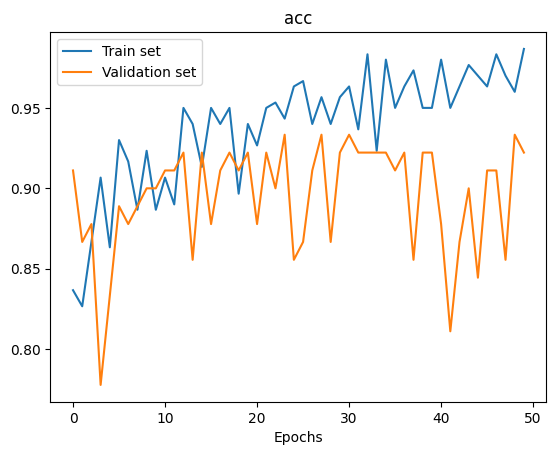

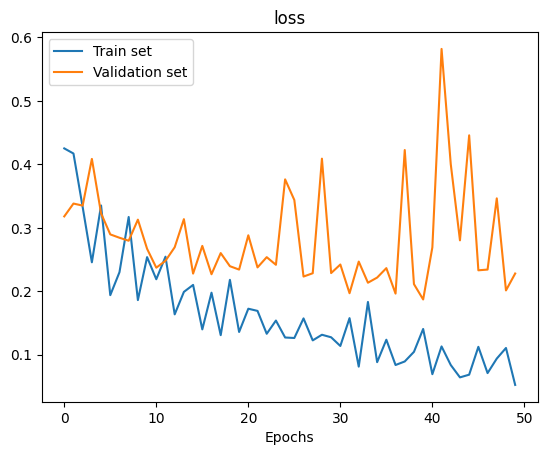

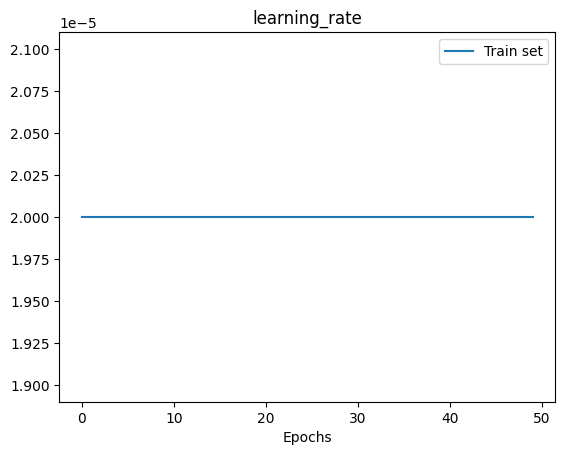

In [26]:
import matplotlib.pyplot as plt

def plot_loss_history(h, title = None):
  for metric in h.history.keys():
    #ignoring metrics on validation set, which are implied when
    #plotting on training set
    if metric.startswith('val_'):
      continue

    #if we get here we found a metric on the training set,
    #let's plot it
    plt.plot(h.history[metric], label = "Train set")

    #do we have a validation counterpart?
    val_label = "val_" + metric
    if val_label in h.history:
      plt.plot(h.history[val_label], label = "Validation set")

    #adding labels on X axis and general title (if present)
    plt.xlabel('Epochs')
    if title is None:
      plt.title(metric)
    else:
      plt.title(title + ' - ' + metric)

    #adding a legend, showing the plot
    plt.legend()
    plt.show()

plot_loss_history(history)